In [ ]:
1.BR1. Phân tích thời tiết (Weather Analysis)

In [1]:
import pandas as pd
import duckdb
import numpy as np
from pathlib import Path

In [2]:
database_path = Path.cwd().parent / "sql/weather.duckdb"
conn = duckdb.connect(str(database_path))
query = """
SELECT 
    W.*,
    C.city_name,
    T.hour,
    full_date,
    day,
    month,
    year,
    quarter,
    is_weekend,
    day_of_week
FROM fact_weather W
JOIN DIM_CITY C ON C.CITY_ID = W.CITY_ID
JOIN DIM_DATE D ON D.DATE_ID = W.DATE_ID
JOIN DIM_TIME T ON T.TIME_ID = W.TIME_ID
"""
df_weather = conn.execute(query=query).fetch_df()
conn.close()

1. Nhiệt độ/Độ ẩm/Gió/Mưa trung bình theo giờ, ngày, tháng, mùa

In [91]:
def avg_weather_by_time(freq: str = 'day', city_id: int = None):
    """
    Tính trung bình nhiệt độ, độ ẩm, mưa, gió theo tần suất freq và thành phố.
    
    freq: 'hour', 'day', 'month'
    city_id: nếu khác None, chỉ lọc city đó
    """
    freq_map = {'hour': ['full_date','hour'], 'day': ['full_date'], 'month': ['year','month']}
    if freq not in freq_map:
        raise ValueError(f"freq phải là một trong {list(freq_map.keys())}")
    
    df_filtered = df_weather.copy()
    if freq == 'hour':
        return df_filtered[['city_id','city_name','hour','rain','wind_speed',
                            'humidity','temperature',]].sort_values(['city_id','hour'],ascending=True)
    # Lọc theo city_id nếu có
    if city_id is not None:
        df_filtered = df_filtered[df_filtered["city_id"] == city_id]
    
    # Xác định group columns
    group_col = ['city_id', 'city_name'] + freq_map[freq]
    
    # Groupby và tính trung bình
    df_grouped = df_filtered.groupby(group_col).agg({
        "temperature": "mean",
        "humidity": "mean",
        "wind_speed": "mean",
        "rain": "mean"
    }).reset_index()
    
    # Đổi tên cột cho dễ đọc
    df_grouped.rename(columns={
        "temperature":"avg_temp",
        "humidity":"avg_hum",
        "wind_speed":"avg_wind",
        "rain":"avg_rain"
    }, inplace=True)
    
    # Sắp xếp theo city + thời gian
    df_grouped = df_grouped.sort_values(['city_id'] + freq_map[freq]).reset_index(drop=True)
    
    return df_grouped


In [93]:
# Nhiệt độ, độ ẩm,tốc độ gió,lượng mưa theo giờ
avg_weather_by_time('hour')

,city_id,city_name,hour,rain,wind_speed,humidity,temperature
0,1,Thành phố Hà Nội,0,0.0,7.4,89.0,19.0
24,1,Thành phố Hà Nội,0,0.0,8.7,95.0,19.9
48,1,Thành phố Hà Nội,0,0.0,9.7,98.0,19.9
72,1,Thành phố Hà Nội,0,0.0,5.4,75.0,15.8
96,1,Thành phố Hà Nội,0,0.0,6.9,90.0,16.6
...,...,...,...,...,...,...,...
93647,96,Tỉnh Cà Mau,23,0.0,20.5,76.0,25.2
93671,96,Tỉnh Cà Mau,23,0.0,18.1,73.0,25.2
93695,96,Tỉnh Cà Mau,23,0.0,17.1,82.0,25.1
93719,96,Tỉnh Cà Mau,23,0.0,13.7,88.0,24.9


In [95]:
# Nhiệt độ, độ ẩm,tốc độ gió,lượng mưa theo ngày
avg_weather_by_time('day')

,city_id,city_name,full_date,avg_temp,avg_hum,avg_wind,avg_rain
0,1,Thành phố Hà Nội,2024-01-01,21.545833,80.333333,8.816667,0.020833
1,1,Thành phố Hà Nội,2024-01-02,22.687500,82.083333,10.762500,0.045833
2,1,Thành phố Hà Nội,2024-01-03,17.987500,80.583333,13.037500,0.400000
3,1,Thành phố Hà Nội,2024-01-04,19.104167,64.291667,8.745833,0.000000
4,1,Thành phố Hà Nội,2024-01-05,20.012500,81.708333,8.020833,0.008333
...,...,...,...,...,...,...,...
1948,96,Tỉnh Cà Mau,2024-01-27,27.145833,67.041667,21.633333,0.000000
1949,96,Tỉnh Cà Mau,2024-01-28,26.962500,67.208333,21.137500,0.000000
1950,96,Tỉnh Cà Mau,2024-01-29,27.041667,68.833333,20.904167,0.000000
1951,96,Tỉnh Cà Mau,2024-01-30,27.087500,69.958333,18.979167,0.000000


In [96]:
# Nhiệt độ, độ ẩm,tốc độ gió,lượng mưa theo tháng
avg_weather_by_time('month')

,city_id,city_name,year,month,avg_temp,avg_hum,avg_wind,avg_rain
0,1,Thành phố Hà Nội,2024,1,17.734005,80.489247,10.172446,0.149462
1,2,Tỉnh Hà Giang,2024,1,16.237769,83.697581,3.762634,0.219355
2,4,Tỉnh Cao Bằng,2024,1,15.107527,82.119624,5.458199,0.143011
3,6,Tỉnh Bắc Kạn,2024,1,15.740726,85.826613,6.650941,0.190323
4,8,Tỉnh Tuyên Quang,2024,1,17.210618,86.607527,4.246102,0.161290
...,...,...,...,...,...,...,...,...
58,92,Thành phố Cần Thơ,2024,1,26.940188,72.544355,10.927688,0.014785
59,93,Tỉnh Hậu Giang,2024,1,26.870296,71.681452,12.045833,0.015054
60,94,Tỉnh Sóc Trăng,2024,1,26.715457,74.702957,22.786156,0.002688
61,95,Tỉnh Bạc Liêu,2024,1,26.068683,83.626344,30.231452,0.001075


2. Biến động nhiệt độ – độ ẩm theo thời gian có xu hướng như thế nào?

In [11]:
import matplotlib.pyplot as plt
def get_national_weather_summary():
    df_nation = df_weather.groupby('month').agg({
        "temperature": "mean",
        "humidity": "mean",
        "wind_speed": "mean",
    }).reset_index()

    df_nation.rename(columns={
        "humidity":"avg_hum",
        "temperature":"avg_temp",
        "wind_speed":"avg_wind"
    },inplace=True)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Trục Y bên trái: nhiệt độ
    ax1.plot(df_nation['month'], df_nation['avg_temp'], label='Avg Temp (°C)', color='red')
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Temperature (°C)", color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Trục Y bên phải: độ ẩm
    ax2 = ax1.twinx()
    ax2.plot(df_nation['month'], df_nation['avg_hum'], label='Avg Hum (%)', color='blue')
    ax2.set_ylabel("Humidity (%)", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title("Biến động Nhiệt độ và Độ ẩm theo tuần (Toàn quốc)")
    plt.grid(True)
    plt.show()



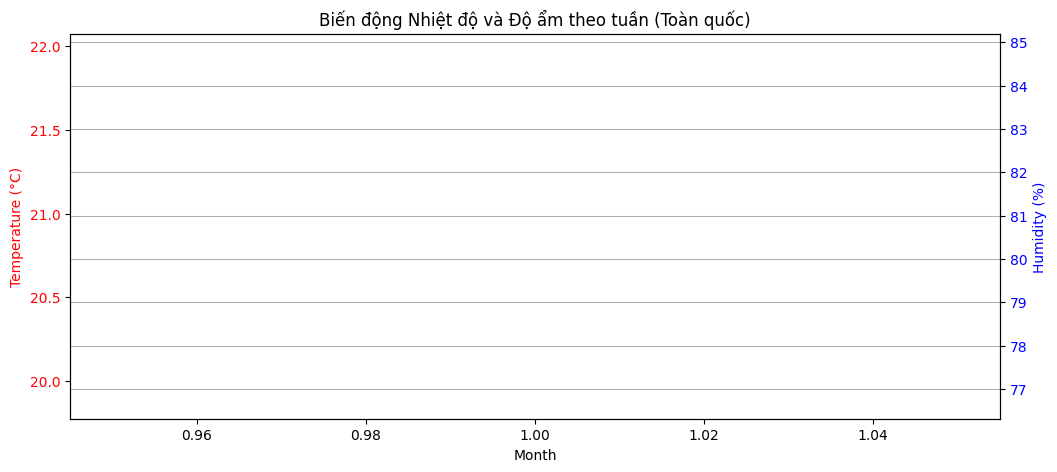

In [12]:
# phân tích xu hướng của nhiệt độ và độ ẩm toàn việt nam
get_national_weather_summary()

 Xu hướng nhiệt độ trong 1 tháng đầu tiên của việt nam là giảm mạnh ở tuần 3 đến tuần 4 từ 22 độ xuống dưới 17 độ và sao đó có dấu hiệu tăng lại
 Xu hướng độ ẩm trong 1 tháng đầu tiên của việt nam giống như nhiệt đọ
 Nên ta có thể kết luận độ ẩm và độ ẩm trong không khí có mối tương quan với nhau

B. Phân tích chất lượng không khí (Air Quality)

In [14]:
database_path = Path.cwd().parent / "sql/weather.duckdb"
conn = duckdb.connect(str(database_path))
query = """
SELECT 
    W.*,
    C.city_name,
    T.hour,
    full_date,
    day,
    month,
    year,
    quarter,
    is_weekend,
    day_of_week
FROM fact_air_quality W
JOIN DIM_CITY C ON C.CITY_ID = W.CITY_ID
JOIN DIM_DATE D ON D.DATE_ID = W.DATE_ID
JOIN DIM_TIME T ON T.TIME_ID = W.TIME_ID
"""
df_air = conn.execute(query=query).fetch_df()
conn.close()

In [15]:
df_air['week'] = df_air['full_date'].dt.isocalendar().week 

1. AQI trung bình theo thành phố/tháng/năm (Historical & Trend)

In [16]:
def get_extreme_avg_aqi_by_time(freq: str):
    """
    Tính AQI trung bình theo thành phố và xếp hạng theo mức ô nhiễm.
    
    Args:
        freq (str): 'month' hoặc 'year'
        
    Returns:
        pd.DataFrame: city_id, city_name, year, (month), avg_aqi, rank
    """

    freq_map = {'month': 'month', 'year': 'year'}
    if freq not in freq_map:
        raise ValueError(f"freq phải là một trong {list(freq_map.keys())}")
    
    # Copy dữ liệu gốc
    df_filtered = df_air.copy()

    # Xác định cột group
    group_col = ['city_id', 'city_name', 'year']
    if freq == 'month':
        group_col.append('month')

    # Tính AQI trung bình
    df_grouped = df_filtered.groupby(group_col).agg({'aqi':'mean'}).reset_index()
    df_grouped.rename(columns={'aqi':'avg_aqi'}, inplace=True)

    # Xác định cột thời gian để xếp hạng
    time_cols = ['year'] if freq == 'year' else ['year','month']

    # Tính rank: rank=1 là ô nhiễm nhất
    df_grouped['rank'] = df_grouped.groupby(time_cols)['avg_aqi'] \
                                   .rank(method='dense', ascending=False)
    
    # Chuyển rank về int cho đẹp
    df_grouped['rank'] = df_grouped['rank'].astype(int)

    # Sắp xếp theo thời gian + rank
    sort_cols = time_cols + ['rank']
    df_grouped = df_grouped.sort_values(sort_cols).reset_index(drop=True)

    return df_grouped


In [17]:
# thành phố có aqi cao nhất theo ngày
get_extreme_avg_aqi_by_time('month')

,city_id,city_name,year,month,avg_aqi,rank
0,72,Tỉnh Tây Ninh,2024,1,59.266129,1
1,80,Tỉnh Long An,2024,1,54.108871,2
2,91,Tỉnh Kiên Giang,2024,1,53.518817,3
3,74,Tỉnh Bình Dương,2024,1,51.244624,4
4,26,Tỉnh Vĩnh Phúc,2024,1,50.509409,5
...,...,...,...,...,...,...
58,4,Tỉnh Cao Bằng,2024,1,30.545699,56
59,14,Tỉnh Sơn La,2024,1,30.275538,57
60,68,Tỉnh Lâm Đồng,2024,1,28.196237,58
61,12,Tỉnh Lai Châu,2024,1,25.922043,59


2. Lọc các ngày ô nhiễm cao

In [18]:
def get_high_aqi_days():
    df_filtered = df_air.copy()
    df_filtered = df_filtered.loc[df_filtered['aqi'] > 150]
    return df_filtered[['aq_id','city_name','full_date','hour','aqi','pm25','pm10','no2','o3','co','so2']]

In [19]:
# Lấy những thời điểm mà thành phó có mức AQI trên 150
get_high_aqi_days()

,aq_id,city_name,full_date,hour,aqi,pm25,pm10,no2,o3,co,so2


3. So sánh ô nhiễm giữa các thành phố

In [20]:
def compare_pollution_metrics_by_city(freq:str):

    freq_map = {'month': 'month', 'year': 'year'}
    if freq not in freq_map:
        raise ValueError(f"freq phải là một trong {list(freq_map.keys())}")
    
    # Copy dữ liệu gốc
    df_filtered = df_air.copy()

    # Xác định cột group
    group_col = ['city_id', 'city_name', 'year']
    if freq == 'month':
        group_col.append('month')

    # Xác định cột thời gian để xếp hạng
    time_cols = ['year'] if freq == 'year' else ['year','month']
    
    df_groupped = df_filtered.groupby(group_col).agg({
        'aqi':'mean',
        'pm25':'mean',
        'pm10':'mean'
    }).reset_index()
    
    df_groupped.rename(columns={
        'aqi':'avg_aqi',
        'pm25':'avg_pm25',
        'pm10':'avg_pm10'
    },inplace=True)

    # Tính rank: rank=1 là ô nhiễm nhất
    df_groupped['rank_aqi'] = df_groupped.groupby(time_cols)['avg_aqi'] \
                                   .rank(method='dense', ascending=False)
    
    df_groupped['rank_pm25'] = df_groupped.groupby(time_cols)['avg_pm25'] \
                                   .rank(method='dense', ascending=False)
    
    df_groupped['rank_pm10'] = df_groupped.groupby(time_cols)['avg_pm10'] \
                                   .rank(method='dense', ascending=False)
    # Chuyển rank về int cho đẹp
    df_groupped['rank_aqi'] = df_groupped['rank_aqi'].astype(int)
    df_groupped['rank_pm25'] = df_groupped['rank_pm25'].astype(int)
    df_groupped['rank_pm10'] = df_groupped['rank_pm10'].astype(int)

    # Sắp xếp theo thời gian + rank
    sort_cols = time_cols + ['rank_aqi']
    df_groupped = df_groupped.sort_values(sort_cols).reset_index(drop=True)

    return df_groupped

In [21]:
# Thành phố nào có mức AQI, PM2.5, PM10 cao/thấp nhất theo tháng/năm trong quá khứ?
compare_pollution_metrics_by_city('month')

,city_id,city_name,year,month,avg_aqi,avg_pm25,avg_pm10,rank_aqi,rank_pm25,rank_pm10
0,72,Tỉnh Tây Ninh,2024,1,59.266129,29.758468,44.775403,1,4,5
1,80,Tỉnh Long An,2024,1,54.108871,25.279435,38.562903,2,8,12
2,91,Tỉnh Kiên Giang,2024,1,53.518817,13.946102,23.612097,3,37,40
3,74,Tỉnh Bình Dương,2024,1,51.244624,24.881720,37.670296,4,11,14
4,26,Tỉnh Vĩnh Phúc,2024,1,50.509409,32.703226,48.219758,5,1,1
...,...,...,...,...,...,...,...,...,...,...
58,4,Tỉnh Cao Bằng,2024,1,30.545699,12.002688,17.531317,56,45,49
59,14,Tỉnh Sơn La,2024,1,30.275538,11.806720,17.165995,57,47,50
60,68,Tỉnh Lâm Đồng,2024,1,28.196237,9.009946,13.739113,58,55,55
61,12,Tỉnh Lai Châu,2024,1,25.922043,8.570968,12.368952,59,56,58


Phân tích mối liên hệ giữa thời tiết và ô nhiễm

In [22]:
def get_weather_pollution_correlation():
    df_merge = df_weather.merge(df_air,on=['city_id','date_id','time_id'],how='inner')
    cor_cols = ['aqi','pm10','pm25','rain','wind_speed','humidity','temperature']
    df_corr_full  = df_merge[cor_cols].corr(method='pearson')
    df_corr = df_corr_full.loc[['aqi','pm10','pm25'],
                             ['rain','wind_speed','humidity','temperature']].copy()
    # Đặt lại tên đẹp
    df_corr.index = ["AQI", "PM2.5", "PM10"]
    df_corr.index.name = "metric"

    return df_corr

In [23]:
get_weather_pollution_correlation()

,rain,wind_speed,humidity,temperature
metric,,,,
AQI,-0.101059,0.122120,-0.398003,0.406271
PM2.5,-0.069218,0.057763,-0.007570,0.050784
PM10,-0.061573,-0.080620,-0.005177,-0.039521



- Nhiệt độ tăng → ô nhiễm tăng.
- Độ ẩm tăng → AQI giảm.
- Gió nhẹ làm khuấy bụi lên → AQI tăng nhẹ.
- Mưa rửa trôi bụi → AQI giảm.

Xác định giờ cao điểm ô nhiễm trong ngày
Các giờ trong ngày nào thường có PM2.5 cao nhất tại từng thành phố?

In [24]:
def get_peak_pollution_hours(limit: int = 1, city_id: int = None):
    """
    Trả về giờ ô nhiễm nhất trong ngày cho từng thành phố.
    
    - limit: số lượng giờ cao điểm muốn lấy (top N)
    - city_id: nếu truyền vào, chỉ lấy thành phố này; nếu None, lấy tất cả
    """
    df = df_air.copy()
    
    # Nhóm theo thành phố + giờ
    df_group = df.groupby(["city_id", "city_name", "hour"]).agg({
        "aqi": "mean"
    }).reset_index()

    # Xếp hạng theo từng thành phố
    df_group["rank_aqi"] = df_group.groupby("city_id")["aqi"] \
                                   .rank(method="first", ascending=False).astype(int)

    # Lọc top limit giờ cao điểm, và lọc theo city_id nếu có
    if city_id is not None:
        df_group = df_group[(df_group["rank_aqi"] <= limit) & (df_group["city_id"] == city_id)]
    else:
        df_group = df_group[df_group["rank_aqi"] <= limit]

    # Sắp xếp đẹp
    df_group = df_group.sort_values(["city_id", "rank_aqi", "hour"]).reset_index(drop=True)

    return df_group


In [26]:
get_peak_pollution_hours(limit=2)

,city_id,city_name,hour,aqi,rank_aqi
0,1,Thành phố Hà Nội,23,53.612903,1
1,1,Thành phố Hà Nội,21,53.193548,2
2,2,Tỉnh Hà Giang,16,37.838710,1
3,2,Tỉnh Hà Giang,17,37.548387,2
4,4,Tỉnh Cao Bằng,16,39.645161,1
...,...,...,...,...,...
121,94,Tỉnh Sóc Trăng,14,47.451613,2
122,95,Tỉnh Bạc Liêu,19,46.870968,1
123,95,Tỉnh Bạc Liêu,22,46.774194,2
124,96,Tỉnh Cà Mau,14,51.677419,1
